## Observational SST Data Exploration

## Download and Combine ERSST v5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from pathlib import Path
import xarray as xr

base_url = "https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/netcdf/"
years = range(1854, 2015)
data_dir = Path("../data/ersst_v5_data")
data_dir.mkdir(parents=True, exist_ok=True)

for year in years:
    filename = f"ersst.v5.{year}01.nc"
    url = base_url + filename
    output_path = data_dir / filename
    if output_path.exists():
        continue
    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(output_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

files = sorted(data_dir.glob("ersst.v5.*.nc"))
if not files:
    raise FileNotFoundError("No ERSST files found in data_dir")

ds = xr.open_mfdataset(
    files,
    combine="by_coords",
    parallel=True,
    decode_times=False,
    use_cftime=True,
    coords="minimal",
    data_vars="minimal",
    compat="override",
    join="override",
)
ds = xr.decode_cf(ds, use_cftime=True)

combined_path = data_dir / "ersst_v5_combined_1854-2014.nc"
ds.to_netcdf(combined_path)
combined_path

C:\Users\altti\AppData\Local\Temp\ipykernel_22564\2584519915.py:41: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.decode_cf(ds, use_cftime=True)


WindowsPath('../data/ersst_v5_data/ersst_v5_combined_1854-2014.nc')

## Initial Exploration

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 8, lev: 1, lat: 89, lon: 180)
Coordinates:
  * time     (time) object 64B 2007-01-01 00:00:00 ... 2007-02-11 13:59:00
  * lev      (lev) float64 8B 0.0
  * lat      (lat) float64 712B -88.0 -86.0 -84.0 -82.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
Data variables:
    sst      (time, lev, lat, lon) float32 513kB ...
    ssta     (time, lev, lat, lon) float32 513kB ...
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.200701
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Co

C:\Users\altti\AppData\Local\Temp\ipykernel_22564\984862452.py:26: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_1860 = xr.open_dataset(year_1860_path, decode_times=True, use_cftime=True)


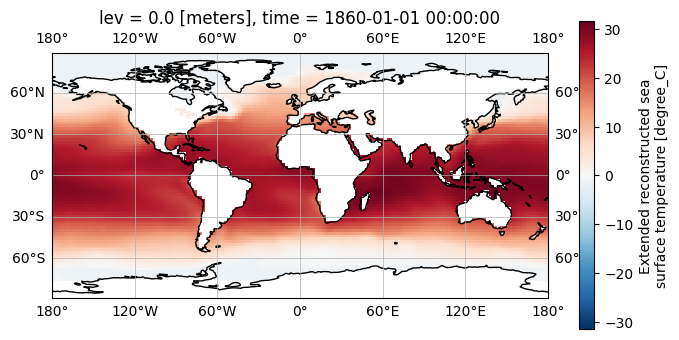

C:\Users\altti\AppData\Local\Temp\ipykernel_22564\984862452.py:45: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds_2014 = xr.open_dataset(year_2014_path, decode_times=True, use_cftime=True)


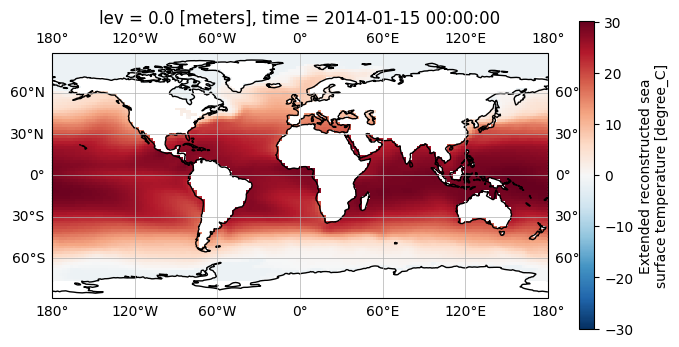

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pathlib import Path

try:
    import cartopy.crs as ccrs
except Exception:
    ccrs = None

combined_file = "../data/ersst_v5_data/ersst_v5_combined_1854-2014.nc"
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
ds = xr.open_dataset(combined_file, decode_times=time_coder)

print(ds)
print("dims:", ds.dims)
print("coords:", list(ds.coords))
print("data_vars:", list(ds.data_vars))

if "sst" in ds.data_vars:
    var_name = "sst"
else:
    var_name = next(v for v in ds.data_vars if not v.endswith("bnds"))

year_1860_path = data_dir / "ersst.v5.186001.nc"
ds_1860 = xr.open_dataset(year_1860_path, decode_times=True, use_cftime=True)
da_1860 = ds_1860[var_name] if var_name in ds_1860.data_vars else next(v for v in ds_1860.data_vars if not v.endswith("bnds"))
if "time" in da_1860.dims:
    map_1860 = da_1860.isel(time=0)
else:
    map_1860 = da_1860

year_2014_path = data_dir / "ersst.v5.201401.nc"
ds_2014 = xr.open_dataset(year_2014_path, decode_times=True, use_cftime=True)
da_2014 = ds_2014[var_name] if var_name in ds_2014.data_vars else next(v for v in ds_2014.data_vars if not v.endswith("bnds"))
if "time" in da_2014.dims:
    map_2014 = da_2014.isel(time=0)
else:
    map_2014 = da_2014

combined = xr.concat([map_1860, map_2014], dim="compare")
vmin = float(combined.min())
vmax = float(combined.max())
diff = map_2014 - map_1860

if ccrs is not None:
    fig, axes = plt.subplots(
        1,
        3,
        subplot_kw={"projection": ccrs.PlateCarree()},
        figsize=(14, 4),
        constrained_layout=True,
    )
    pcm0 = map_1860.plot(
        ax=axes[0],
        transform=ccrs.PlateCarree(),
        x="lon",
        y="lat",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
    )
    pcm1 = map_2014.plot(
        ax=axes[1],
        transform=ccrs.PlateCarree(),
        x="lon",
        y="lat",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
    )
    pcm2 = diff.plot(
        ax=axes[2],
        transform=ccrs.PlateCarree(),
        x="lon",
        y="lat",
        cmap="RdBu_r",
        center=0,
        add_colorbar=False,
    )
    for ax in axes:
        ax.coastlines()
        ax.gridlines(draw_labels=True, linewidth=0.5)
else:
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
    pcm0 = map_1860.plot(ax=axes[0], x="lon", y="lat", vmin=vmin, vmax=vmax, add_colorbar=False)
    pcm1 = map_2014.plot(ax=axes[1], x="lon", y="lat", vmin=vmin, vmax=vmax, add_colorbar=False)
    pcm2 = diff.plot(ax=axes[2], x="lon", y="lat", cmap="RdBu_r", center=0, add_colorbar=False)

axes[0].set_title("1860 map")
axes[1].set_title("2014 map")
axes[2].set_title("2014 - 1860")
fig.colorbar(pcm0, ax=axes[:2], orientation="vertical", shrink=0.85, label=var_name)
fig.colorbar(pcm2, ax=axes[2], orientation="vertical", shrink=0.85, label=f"Delta {var_name}")
plt.show()

ds_1860.close()
ds_2014.close()